In [5]:
# pip install pandas matplotlib numpy seaborn scikit-learn statsmoddels 

In [5]:
import pandas as pd
import sklearn as sk
import seaborn
import matplotlib as plt
import numpy as np

In [6]:
data = pd.read_csv("data.csv")
bmw_data = data[(data["Make"] == "BMW") & (data["Model"] == "3 Series 328i")]
bmw_data = bmw_data.drop(columns=["Make","Model"])

## Marca: BMW modelo: 3 Series 328i


In [7]:
num_doors_not_4 = (bmw_data["Doors"] != 4).sum()
print(f"Número de autos con Doors != 4: {num_doors_not_4}")

num_doors_4 = (bmw_data["Doors"] == 4).sum()
print(f"Número de autos con Doors == 4: {num_doors_4}")

transm = (bmw_data["Transmission"] != "Automatic").sum()
print(f"Número de autos con Transmision != Atomatica: {transm}")


Número de autos con Doors != 4: 32
Número de autos con Doors == 4: 109
Número de autos con Transmision != Atomatica: 6


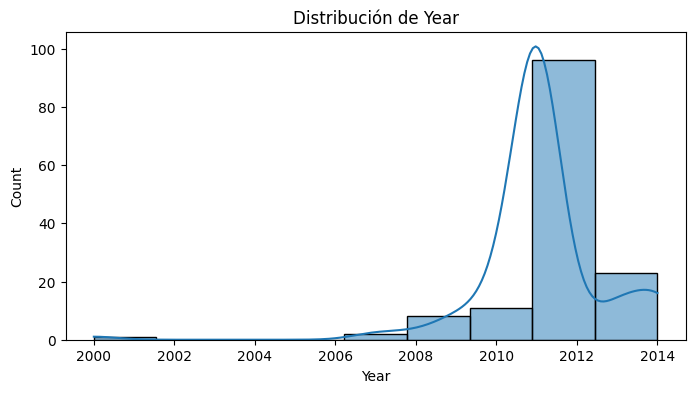

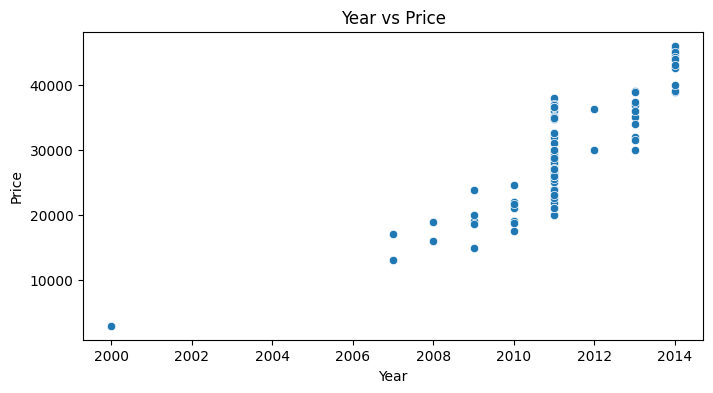

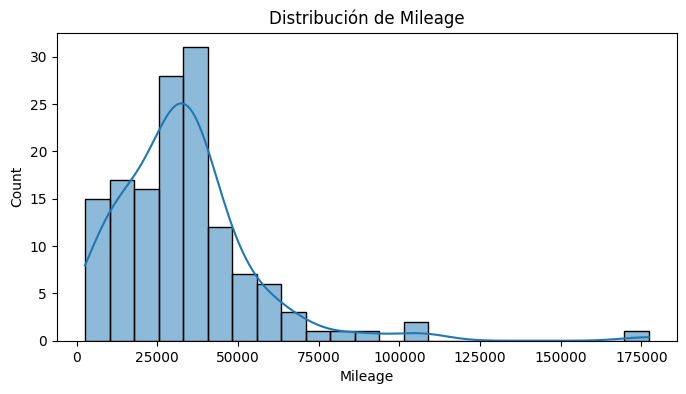

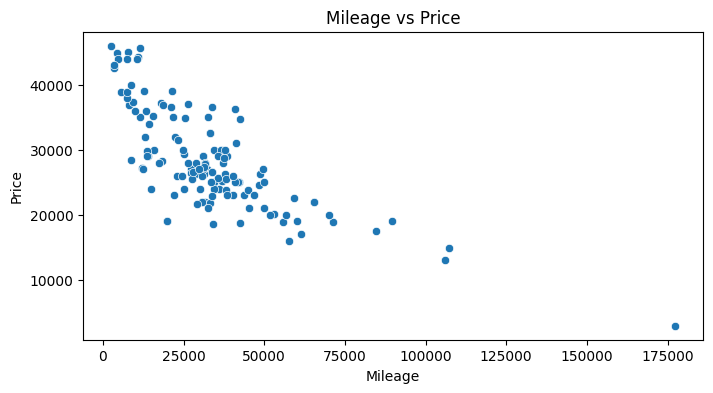

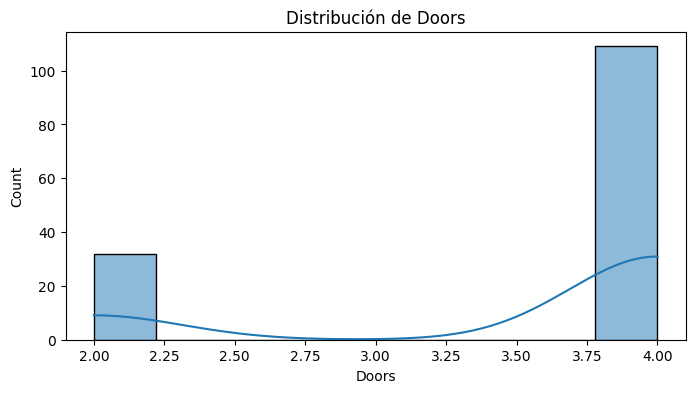

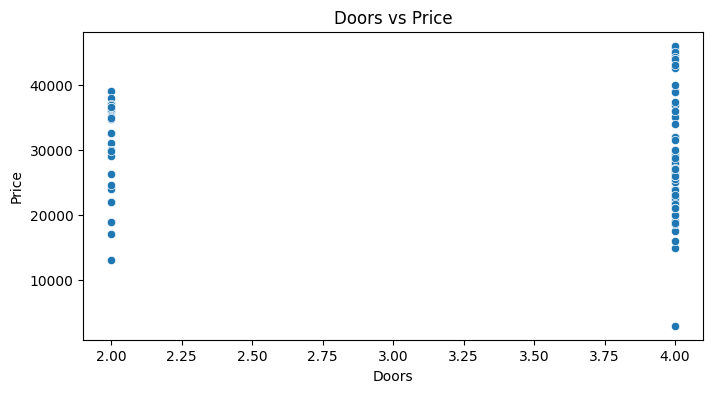

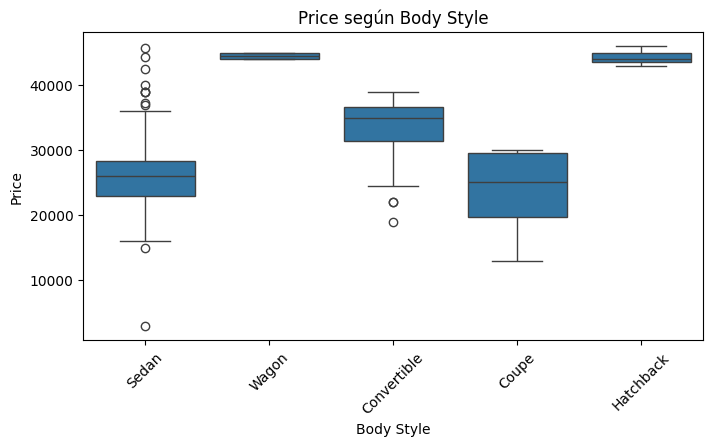

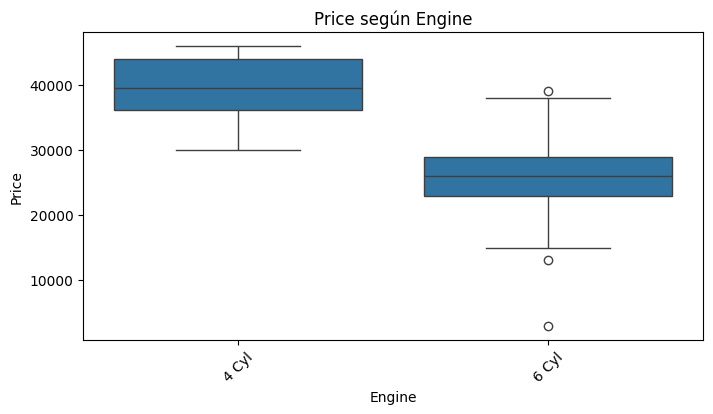

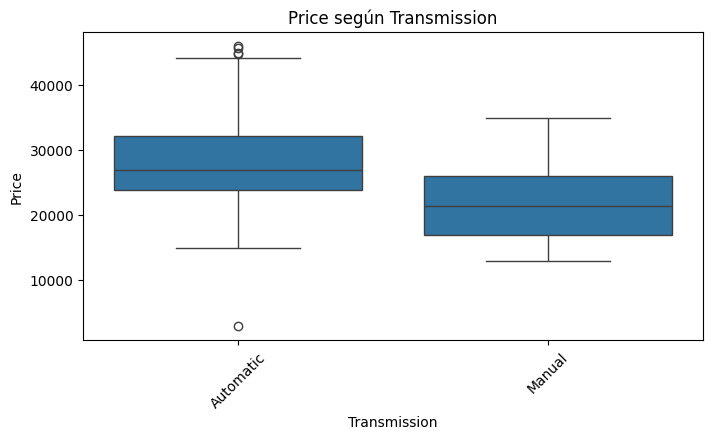

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt

numeric_cols = ['Year', 'Mileage', 'Doors']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=bmw_data, x=col, kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=bmw_data, x=col, y='Price')
    plt.title(f'{col} vs Price')
    plt.show()

categorical_cols = ['Body Style', 'Engine', 'Transmission']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=bmw_data, x=col, y='Price')
    plt.title(f'Price según {col}')
    plt.xticks(rotation=45)
    plt.show()

In [9]:
df = bmw_data
df = pd.get_dummies(df, drop_first=True)

correlations = df.corr()

print(correlations.head(10))
print(correlations.tail(10))
aa = np.linalg.det(correlations)
print(aa)
print(df.var())


                          Year   Mileage     Price     Doors  \
Year                  1.000000 -0.802932  0.814472  0.168136   
Mileage              -0.802932  1.000000 -0.746384 -0.085763   
Price                 0.814472 -0.746384  1.000000 -0.140197   
Doors                 0.168136 -0.085763 -0.140197  1.000000   
Body Style_Coupe     -0.187864  0.134546 -0.153661 -0.509921   
Body Style_Hatchback  0.266909 -0.190308  0.321403  0.079888   
Body Style_Sedan     -0.043473  0.056360 -0.374272  0.876253   
Body Style_Wagon      0.309323 -0.202809  0.375335  0.092583   
Ex Color_Blue        -0.122018  0.062639 -0.158653 -0.000331   
Ex Color_Gold        -0.004851  0.002161  0.095224 -0.155982   

                      Body Style_Coupe  Body Style_Hatchback  \
Year                         -0.187864              0.266909   
Mileage                       0.134546             -0.190308   
Price                        -0.153661              0.321403   
Doors                        -0.509921 

In [10]:
color_columns = [col for col in df.columns if col.startswith("Ex Color_") or col.startswith("In Color_")]
df_color_price = df[["Price"] + color_columns]
correlacion = df_color_price.corr()
determinant = np.linalg.det(correlacion)
print(determinant) #Si tuvieramos solo las variables de in y ex color, tendríamos problemas de dependencia entre variables

0.27995958909043406


In [11]:
df_sin = df.drop(columns=color_columns)
correlations = df_sin.corr()
a = np.linalg.det(correlations)
print(a)
print(a-aa)

5.254210453748277e-18
4.4843745490173175e-18


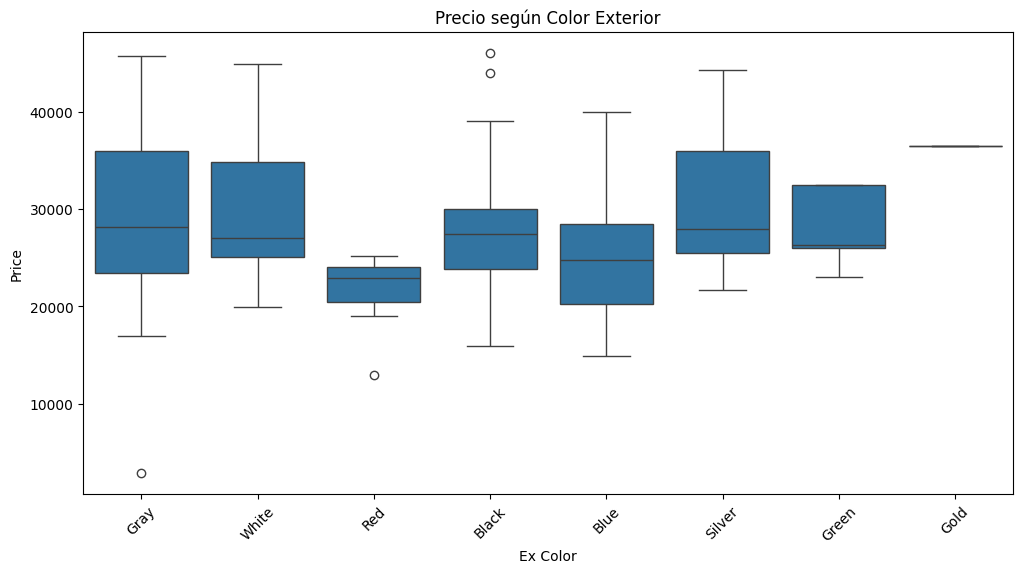

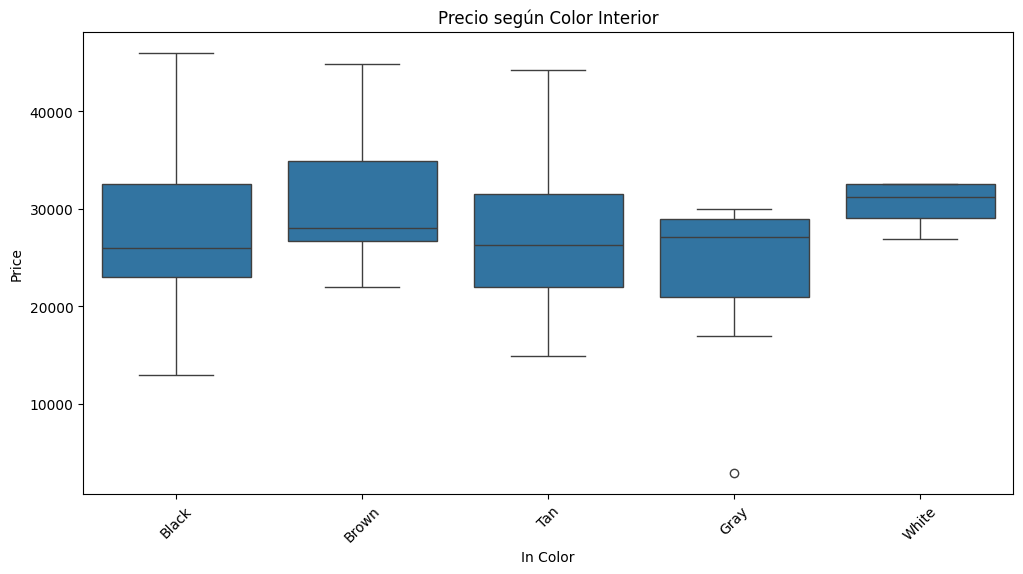

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="Ex Color", y="Price", data=bmw_data)
plt.title("Precio según Color Exterior")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="In Color", y="Price", data=bmw_data)
plt.title("Precio según Color Interior")
plt.xticks(rotation=45)
plt.show()

In [13]:
bmw_data = bmw_data.drop(columns=["Ex Color", "In Color"])

## B. Selección del modelo


In [14]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(bmw_data, test_size=0.4, random_state=42)
test_data = bmw_data.drop(train_data.index)
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
train_data = train_data.fillna(0)
X = train_data.drop(columns=["Price"])
model.fit(X, train_data["Price"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Analizamos los datos de autos BMW 3 Series 328i, explorando variables numéricas y categóricas, y evaluamos la relación entre características y precio. Posteriormente, entrenamos modelos de regresión lineal 

In [15]:
test_data = test_data.fillna(0)
X_test = test_data.drop(columns=["Price"])
predictions = model.predict(X_test)

In [16]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_data["Price"], predictions)
print(f"R2 score: {r2:.4f}")


R2 score: 0.8120


Nuestro modelo de regresion lineal tiene un R² = 0.81

In [17]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

X_poly_base = X.copy()
y = train_data["Price"]

results = []
max_degree = 5

for degree in range(1, max_degree + 1):
    poly = PolynomialFeatures(degree, include_bias=False)
    X_poly = poly.fit_transform(X_poly_base)
    
    scaler = StandardScaler()
    X_poly_scaled = scaler.fit_transform(X_poly)
    
    lasso = Lasso(alpha=0.1, max_iter=50000) 
    lasso.fit(X_poly_scaled, y)
    
    X_test_poly = poly.transform(X_test)
    X_test_poly_scaled = scaler.transform(X_test_poly)
    y_pred = lasso.predict(X_test_poly_scaled)
    
    r2 = r2_score(test_data["Price"], y_pred)
    mse = mean_squared_error(test_data["Price"], y_pred)
    results.append({"degree": degree, "r2": r2, "mse": mse})
    
for res in results:
    print(f"Lasso Degree: {res['degree']}, R2: {res['r2']:.4f}, MSE: {res['mse']:.2f}")


/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.226e+07, tolerance: 4.944e+05
  model = cd_fast.enet_coordinate_descent(
/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e+06, tolerance: 4.944e+05
  model = cd_fast.enet_coordinate_descent(
/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

Lasso Degree: 1, R2: 0.8121, MSE: 9416925.82
Lasso Degree: 2, R2: 0.8623, MSE: 6899438.10
Lasso Degree: 3, R2: -4.0599, MSE: 253523693.80
Lasso Degree: 4, R2: -185.0512, MSE: 9322023287.46
Lasso Degree: 5, R2: -624.6982, MSE: 31350373639.82


/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.361e+07, tolerance: 4.944e+05
  model = cd_fast.enet_coordinate_descent(


Escalamos las variables y a partir de ello generamos polinomios hasta el grado 5, lo cual en la mayoría de modelos, las variables categóricas por su baja varianza y señales de alta colinealidad generan problemas para modelos de regresion, se uso regularizacion lasso, mostró mejores métricas que ridge

In [18]:
pd.Series(lasso.coef_, index=poly.get_feature_names_out(X_poly_base.columns))


Year                                                -0.000000
Mileage                                              0.000000
Doors                                            -1076.432138
Body Style_Convertible                               0.000000
Body Style_Coupe                                    19.649076
                                                     ...     
Transmission_Automatic^4 Transmission_Manual         0.000000
Transmission_Automatic^3 Transmission_Manual^2       0.000000
Transmission_Automatic^2 Transmission_Manual^3       0.000000
Transmission_Automatic Transmission_Manual^4         0.000000
Transmission_Manual^5                                0.000000
Length: 6187, dtype: float64

In [19]:
import pandas as pd

coef_df = pd.DataFrame({
    'feature': poly.get_feature_names_out(X_poly_base.columns),
    'coef': lasso.coef_
})
coef_df = coef_df[coef_df['coef'] != 0].sort_values(by='coef', ascending=False)
print(coef_df)



                                     feature          coef
3191                  Mileage^4 Engine_4 Cyl  18029.388582
3252      Mileage^2 Doors^2 Body Style_Coupe  16750.098534
3197        Mileage^3 Doors Body Style_Coupe  11752.101533
3186        Mileage^4 Body Style_Convertible  10239.838527
2196   Year Mileage^2 Doors Body Style_Coupe   7727.740223
...                                      ...           ...
181           Mileage Doors Body Style_Coupe  -6445.708319
3256          Mileage^2 Doors^2 Engine_4 Cyl  -6697.050630
3201            Mileage^3 Doors Engine_4 Cyl -12199.479519
3196  Mileage^3 Doors Body Style_Convertible -13043.744681
3187              Mileage^4 Body Style_Coupe -24844.396249

[292 rows x 2 columns]


La celda anterior muestra los coeficientes del modelo Lasso polinomia. Esto permite identificar qué variables (o combinaciones polinómicas de variables) tienen mayor influencia en la predicción del precio del auto. Solo se muestran los coeficientes diferentes de cero, lo que ayuda a visualizar las características más relevantes seleccionadas por el modelo tras la regularización.

In [20]:
import pandas as pd

coef_df = pd.DataFrame({
    'feature': poly.get_feature_names_out(X_poly_base.columns),
    'coef': lasso.coef_
})
coef_df = coef_df[coef_df['coef'] != 0]
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)
print(coef_df.head(20))


                                     feature          coef      abs_coef
3187              Mileage^4 Body Style_Coupe -24844.396249  24844.396249
3191                  Mileage^4 Engine_4 Cyl  18029.388582  18029.388582
3252      Mileage^2 Doors^2 Body Style_Coupe  16750.098534  16750.098534
3196  Mileage^3 Doors Body Style_Convertible -13043.744681  13043.744681
3201            Mileage^3 Doors Engine_4 Cyl -12199.479519  12199.479519
3197        Mileage^3 Doors Body Style_Coupe  11752.101533  11752.101533
3186        Mileage^4 Body Style_Convertible  10239.838527  10239.838527
2196   Year Mileage^2 Doors Body Style_Coupe   7727.740223   7727.740223
831         Mileage^2 Doors Body Style_Coupe   7610.565605   7610.565605
171               Mileage^2 Body Style_Coupe   7205.558675   7205.558675
535          Year Mileage^2 Body Style_Coupe   6864.947190   6864.947190
3256          Mileage^2 Doors^2 Engine_4 Cyl  -6697.050630   6697.050630
1900       Year^2 Mileage^2 Body Style_Coupe   6531

## Cross - Val

In [21]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

In [22]:
X_poly_base = X.copy()
y = train_data["Price"]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_poly_base)
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.logspace(-3,1,50), cv=kf, max_iter=50000)
lasso_cv.fit(X_poly_scaled, y)

print(f"Mejor alpha: {lasso_cv.alpha_:.4f}")
X_test_poly = poly.transform(X_test)
X_test_scaled = scaler.transform(X_test_poly)
y_test = test_data["Price"]
y_pred = lasso_cv.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R2: {r2:.4f}, MSE: {mse:.2f}")



/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.021e+06, tolerance: 4.025e+05
  model = cd_fast.enet_coordinate_descent(
/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.804e+06, tolerance: 4.025e+05
  model = cd_fast.enet_coordinate_descent(
/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations

Mejor alpha: 10.0000
R2: 0.8548, MSE: 7272751.03


/home/juan/Escritorio/Avanzado/proyecto1/mi_venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e+08, tolerance: 4.194e+05
  model = cd_fast.enet_coordinate_descent(


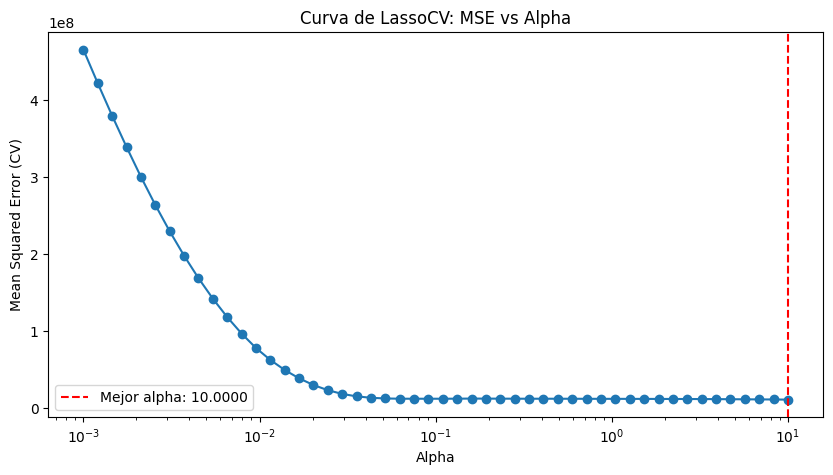

In [24]:
import matplotlib.pyplot as plt
import numpy as np

alphas = lasso_cv.alphas_
mse_path = np.mean(lasso_cv.mse_path_, axis=1)

plt.figure(figsize=(10,5))
plt.plot(alphas, mse_path, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (CV)')
plt.title('Curva de LassoCV: MSE vs Alpha')
plt.axvline(lasso_cv.alpha_, color='red', linestyle='--', label=f'Mejor alpha: {lasso_cv.alpha_:.4f}')
plt.legend()
plt.show()


se implementó validación cruzada para ajustar el modelo Lasso polinomial. Se utilizó `LassoCV` junto con `KFold` para encontrar el mejor valor de regularización (`alpha`) y evaluar el desempeño del modelo en los datos de prueba. Se escalaron las variables y se generaron polinomios de grado 2, mostrando el valor óptimo de alpha y las métricas de desempeño (R² y MSE). Finalmente, se graficó la curva de error medio cuadrático (MSE) en función de alpha para visualizar el proceso de selección del hiperparámetro.